<a href="https://colab.research.google.com/github/RubaNadeem/RubaNadeem/blob/main/Task_3_Customer_Segmentation_Using_RFM_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#Cell 1: Upload dataset
from google.colab import files
uploaded = files.upload()



Saving Online Retail.xlsx to Online Retail (1).xlsx


In [4]:
#Cell 2: Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt


In [5]:
#Cell 3: Load dataset
df = pd.read_excel("Online Retail.xlsx")
df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [7]:
#3) Clean & feature engineering
#Drop missing CustomerID
#Remove cancelled invoices (InvoiceNo starts with “C”)
#Keep only positive quantities/prices
#Create TotalAmount = Quantity × UnitPrice

df = df.dropna(subset=['CustomerID'])
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]
df['TotalAmount'] = df['Quantity'] * df['UnitPrice']

df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalAmount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [8]:
#4) Reference date (for Recency)

reference_date = df['InvoiceDate'].max() + dt.timedelta(days=1)
reference_date


Timestamp('2011-12-10 12:50:00')

In [9]:
#5) Compute RFM metrics
#Recency = days since last purchase
#Frequency = unique invoices
#Monetary = sum of spend

rfm = (
    df.groupby('CustomerID')
      .agg({
          'InvoiceDate': lambda x: (reference_date - x.max()).days,
          'InvoiceNo': 'nunique',
          'TotalAmount': 'sum'
      })
      .reset_index()
      .rename(columns={
          'InvoiceDate': 'Recency',
          'InvoiceNo': 'Frequency',
          'TotalAmount': 'Monetary'
      })
)
rfm.head()


,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,1,77183.60
1,12347.0,2,7,4310.00
2,12348.0,75,4,1797.24
3,12349.0,19,1,1757.55
4,12350.0,310,1,334.40


In [10]:
#6) Score R, F, M (1–5) and build RFM_Score
#Lower Recency is better → reverse labels
#Use rank for Frequency to avoid ties

# Robust qcut (handles ties better); if you ever see "Bin edges must be unique", set duplicates='drop'
rfm['R'] = pd.qcut(rfm['Recency'], 5, labels=[5,4,3,2,1])
rfm['F'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1,2,3,4,5])
rfm['M'] = pd.qcut(rfm['Monetary'], 5, labels=[1,2,3,4,5])

rfm['RFM_Score'] = rfm[['R','F','M']].astype(int).sum(axis=1)
rfm.head()


,CustomerID,Recency,Frequency,Monetary,R,F,M,RFM_Score
0,12346.0,326,1,77183.60,1,1,5,7
1,12347.0,2,7,4310.00,5,5,5,15
2,12348.0,75,4,1797.24,2,4,4,10
3,12349.0,19,1,1757.55,4,1,4,9
4,12350.0,310,1,334.40,1,1,2,4


In [11]:
#7) Segment customers + simple marketing ideas

def segment_customer(score: int) -> str:
    if score >= 12:
        return 'Champions'
    elif score >= 9:
        return 'Loyal Customers'
    elif score >= 6:
        return 'Potential Loyalists'
    elif score >= 3:
        return 'At Risk'
    else:
        return 'Lost Customers'

rfm['Segment'] = rfm['RFM_Score'].apply(segment_customer)

strategies = {
    'Champions': 'VIP rewards, early access, exclusive bundles',
    'Loyal Customers': 'Cross-sell/upsell, loyalty points, subscriptions',
    'Potential Loyalists': 'Targeted discounts, personalized recommendations',
    'At Risk': 'Re-engagement emails, limited-time offers, feedback',
    'Lost Customers': 'Win-back campaign with strong incentives'
}
rfm['Strategy'] = rfm['Segment'].map(strategies)

rfm[['CustomerID','Recency','Frequency','Monetary','RFM_Score','Segment','Strategy']].head(10)


,CustomerID,Recency,Frequency,Monetary,RFM_Score,Segment,Strategy
0,12346.0,326,1,77183.60,7,Potential Loyalists,"Targeted discounts, personalized recommendations"
1,12347.0,2,7,4310.00,15,Champions,"VIP rewards, early access, exclusive bundles"
2,12348.0,75,4,1797.24,10,Loyal Customers,"Cross-sell/upsell, loyalty points, subscriptions"
3,12349.0,19,1,1757.55,9,Loyal Customers,"Cross-sell/upsell, loyalty points, subscriptions"
4,12350.0,310,1,334.40,4,At Risk,"Re-engagement emails, limited-time offers, fee..."
5,12352.0,36,8,2506.04,13,Champions,"VIP rewards, early access, exclusive bundles"
6,12353.0,204,1,89.00,3,At Risk,"Re-engagement emails, limited-time offers, fee..."
7,12354.0,232,1,1079.40,6,Potential Loyalists,"Targeted discounts, personalized recommendations"
8,12355.0,214,1,459.40,4,At Risk,"Re-engagement emails, limited-time offers, fee..."
9,12356.0,23,3,2811.43,12,Champions,"VIP rewards, early access, exclusive bundles"


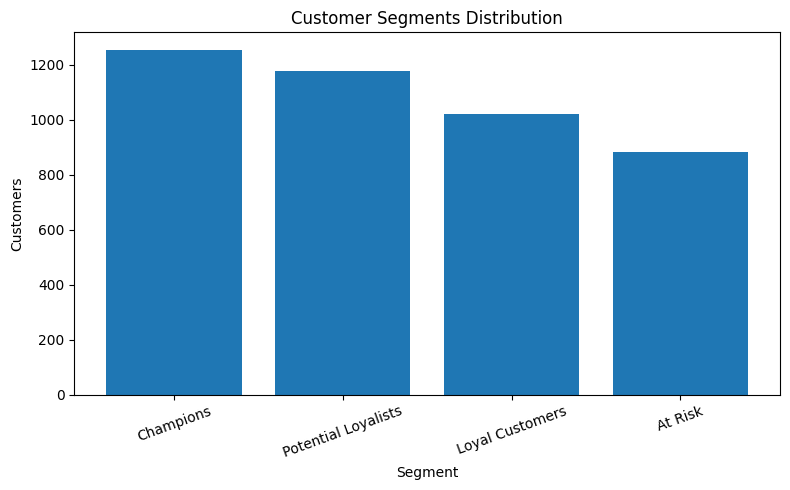

In [12]:
#8) Visualize segments (bar chart)
counts = rfm['Segment'].value_counts().sort_values(ascending=False)

plt.figure(figsize=(8,5))
plt.bar(counts.index, counts.values)
plt.title('Customer Segments Distribution')
plt.xlabel('Segment'); plt.ylabel('Customers')
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()


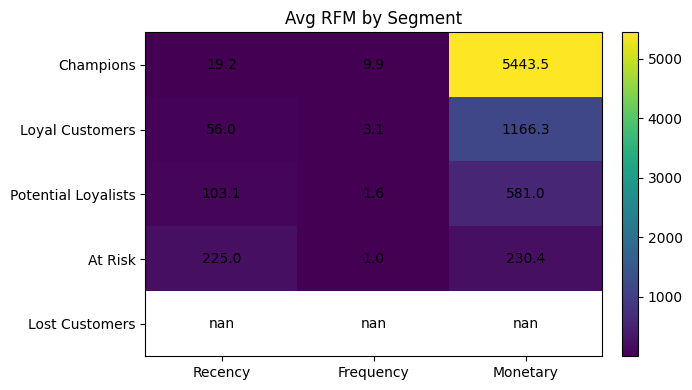

In [14]:
#9) Bonus: Heatmap-style view of avg R/F/M per segment

summary = (
    rfm.groupby('Segment')
       .mean(numeric_only=True)[['Recency','Frequency','Monetary']]
       .reindex(['Champions','Loyal Customers','Potential Loyalists','At Risk','Lost Customers'])
)

data = summary.values
fig, ax = plt.subplots(figsize=(7,4))
im = ax.imshow(data, aspect='auto')
for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        ax.text(j, i, f'{data[i,j]:.1f}', ha='center', va='center')
ax.set_xticks(range(summary.shape[1])); ax.set_xticklabels(summary.columns)
ax.set_yticks(range(summary.shape[0])); ax.set_yticklabels(summary.index)
ax.set_title('Avg RFM by Segment')
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout(); plt.show()


In [15]:
#10) Export results (and download in Colab)
# Save
rfm.to_csv('rfm_output.csv', index=False)

# Download to your computer
from google.colab import files
files.download('rfm_output.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>